In [1]:
from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# Define the path where the dictionary is saved
file_path = 'C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/cleaned_data.pkl'

# Load the dictionary from the file
with open(file_path, 'rb') as f:
    data_dict = pickle.load(f)



In [3]:
import numpy as np

# Extract cloud imagery data (lat, lon, rgb) for all Julian days into separate arrays
cloud_imagery_lat = np.array([data_dict[day]['cloud_imagery']['lat'] for day in data_dict])
cloud_imagery_lon = np.array([data_dict[day]['cloud_imagery']['lon'] for day in data_dict])
cloud_imagery_rgb = np.array([data_dict[day]['cloud_imagery']['rgb'] for day in data_dict])

# Extract reflected shortwave radiation (lat, lon, rsr) for all Julian days into separate arrays
reflected_sw_lat = np.array([data_dict[day]['reflected_sw']['lat'] for day in data_dict])
reflected_sw_lon = np.array([data_dict[day]['reflected_sw']['lon'] for day in data_dict])
reflected_sw_rsr = np.array([data_dict[day]['reflected_sw']['rsr'] for day in data_dict])

# Extract cloud optical depth (lat, lon, cod) for all Julian days into separate arrays
cloud_optical_depth_lat = np.array([data_dict[day]['cloud_optical_depth']['lat'] for day in data_dict])
cloud_optical_depth_lon = np.array([data_dict[day]['cloud_optical_depth']['lon'] for day in data_dict])
cloud_optical_depth_cod = np.array([data_dict[day]['cloud_optical_depth']['cod'] for day in data_dict])

# Verify by printing the shape of the arrays
print("Cloud Imagery RGB Shape:", cloud_imagery_rgb.shape)
print("Reflected SW RSR Shape:", reflected_sw_rsr.shape)
print("Cloud Optical Depth COD Shape:", cloud_optical_depth_cod.shape)


Cloud Imagery RGB Shape: (10, 1500, 2499, 3)
Reflected SW RSR Shape: (10, 166, 394)
Cloud Optical Depth COD Shape: (10, 1500, 2500)


In [6]:
dataset_metadata = {
    "title": "RGB Cloud Imagery",
    "description": "Combined RGB cloud imagery data over time for Julian days 91 to 100.",
    "source": "GOES-16 Satellite Cloud and Moisture Imagery",
    "history": "Created on 2024-10-24 by combining RGB imagery over time.",
    "institution": "University of Washington",
    "references": "https://registry.opendata.aws/noaa-goes/",
    "comment": "Truncated longitude to match RGB data, latitude and longitude represent cloud imagery grids.",
    "time_units": "Julian days",
    "lat_units": "degrees_north",
    "lon_units": "degrees_east",
    "rgb_units": "RGB intensity [0-255]"
}
# Assuming time is represented by the Julian days 91 to 100
time = np.array([91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

# Extract the RGB data and lat/lon for all days
cloud_imagery_rgb = np.array([data_dict[day]['cloud_imagery']['rgb'] for day in data_dict])

# Extract lat/lon for each day (assuming lat/lon are 2D for each day)
cloud_imagery_lat = np.array([data_dict[day]['cloud_imagery']['lat'][:,:-1] for day in data_dict])
cloud_imagery_lon = np.array([data_dict[day]['cloud_imagery']['lon'][:,:-1] for day in data_dict])

# Stack the RGB data into a 4D array (time, lat, lon, rgb)
rgb_data = np.stack(cloud_imagery_rgb, axis=0)

# Create the xarray Dataset with renamed coordinates
CloudImageryDataset = xr.Dataset(
    {
        'CloudImagery': (['time', 'latitude', 'longitude', 'rgb'], rgb_data)
    },
    coords={
        "time": ("time", time, {"units": dataset_metadata["time_units"]}),  # Add units directly to time
        "lat": (['time', 'latitude', 'longitude'], cloud_imagery_lat, {"units": dataset_metadata["lat_units"]}),  # 1D latitude
        "lon": (['time', 'latitude', 'longitude'], cloud_imagery_lon, {"units": dataset_metadata["lon_units"]}),  # 1D longitude
        "rgb": ("rgb", ["red", "green", "blue"], {"units": dataset_metadata["rgb_units"]})  # Add units to RGB
    },
    # name="CloudImagery",
    attrs=dataset_metadata  # Add metadata here
    
)

# Verify the structure of the Dataset
# print(ds)


In [7]:
CloudImageryDataset

<xarray.Dataset>
Dimensions:       (time: 10, latitude: 1500, longitude: 2499, rgb: 3)
Coordinates:
  * time          (time) int32 91 92 93 94 95 96 97 98 99 100
    lat           (time, latitude, longitude) float32 57.3 57.3 ... 14.64 14.64
    lon           (time, latitude, longitude) float32 0.2618 0.2618 ... -61.93
  * rgb           (rgb) <U5 'red' 'green' 'blue'
Dimensions without coordinates: latitude, longitude
Data variables:
    CloudImagery  (time, latitude, longitude, rgb) float32 nan nan ... 0.0 0.0
Attributes:
    title:        RGB Cloud Imagery
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

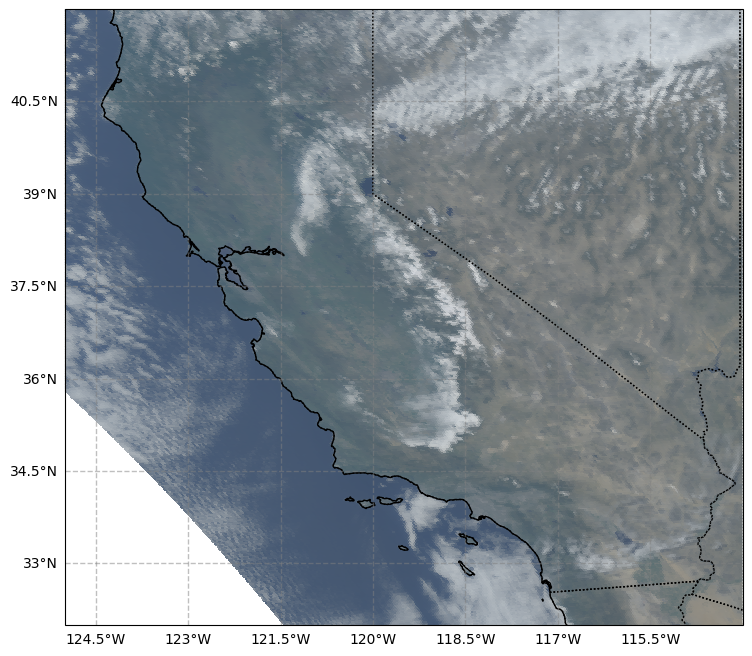

In [8]:
RGB = np.dstack([CloudImageryDataset['CloudImagery'][0,:,:,0], CloudImageryDataset['CloudImagery'][0,:,:,1], CloudImageryDataset['CloudImagery'][0,:,:,2]])
rgb = RGB[:,:,:]

# Create the plot using cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(CloudImageryDataset['lon'][0,:], CloudImageryDataset['lat'][0,:], rgb, transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()

In [9]:
dataset_metadata = {
    "title": "Cloud Optical Depth",
    "description": "Combined cloud optical depth data over time for Julian days 91 to 100.",
    "source": "GOES-16 Satellite Cloud and Moisture Imagery",
    "history": "Created on 2024-10-24 by combining RGB imagery over time.",
    "institution": "University of Washington",
    "references": "https://registry.opendata.aws/noaa-goes/",
    "time_units": "Julian days",
    "lat_units": "degrees_north",
    "lon_units": "degrees_east",
    "cod_units": "dimensionless"
}
# Assuming time is represented by the Julian days 91 to 100
time = np.array([91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

# Extract the RGB data and lat/lon for all days
cloud_optical_depth_cod = np.array([data_dict[day]['cloud_optical_depth']['cod'] for day in data_dict])

# Extract lat/lon for each day (assuming lat/lon are 2D for each day)
cloud_optical_depth_lat = np.array([data_dict[day]['cloud_optical_depth']['lat'][:,:] for day in data_dict])
cloud_optical_depth_lon = np.array([data_dict[day]['cloud_optical_depth']['lon'][:,:] for day in data_dict])

# Stack the RGB data into a 4D array (time, lat, lon, rgb)
cod_data = np.stack(cloud_optical_depth_cod, axis=0)

# Create the xarray Dataset with renamed coordinates
CloudOpticalDepthDataset = xr.Dataset(
    {
        'CloudOpticalDepth': (['time', 'latitude', 'longitude'], cod_data)
    },
    coords={
        "time": ("time", time, {"units": dataset_metadata["time_units"]}),  # Add units directly to time
        "lat": (['time', 'latitude', 'longitude'], cloud_optical_depth_lat, {"units": dataset_metadata["lat_units"]}),  # 1D latitude
        "lon": (['time', 'latitude', 'longitude'], cloud_optical_depth_lon, {"units": dataset_metadata["lon_units"]}),  # 1D longitude
    },
    # name="CloudImagery",
    attrs=dataset_metadata  # Add metadata here
    
)

# Verify the structure of the Dataset
# print(ds)


In [15]:
CloudOpticalDepthDataset

<xarray.Dataset>
Dimensions:            (time: 10, latitude: 1500, longitude: 2500)
Coordinates:
  * time               (time) int32 91 92 93 94 95 96 97 98 99 100
    lat                (time, latitude, longitude) float32 57.3 57.3 ... 14.64
    lon                (time, latitude, longitude) float32 0.2618 ... -61.91
Dimensions without coordinates: latitude, longitude
Data variables:
    CloudOpticalDepth  (time, latitude, longitude) float32 nan nan ... nan
Attributes:
    title:        Cloud Optical Depth
    description:  Combined cloud optical depth data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    cod_units:    dimensionless

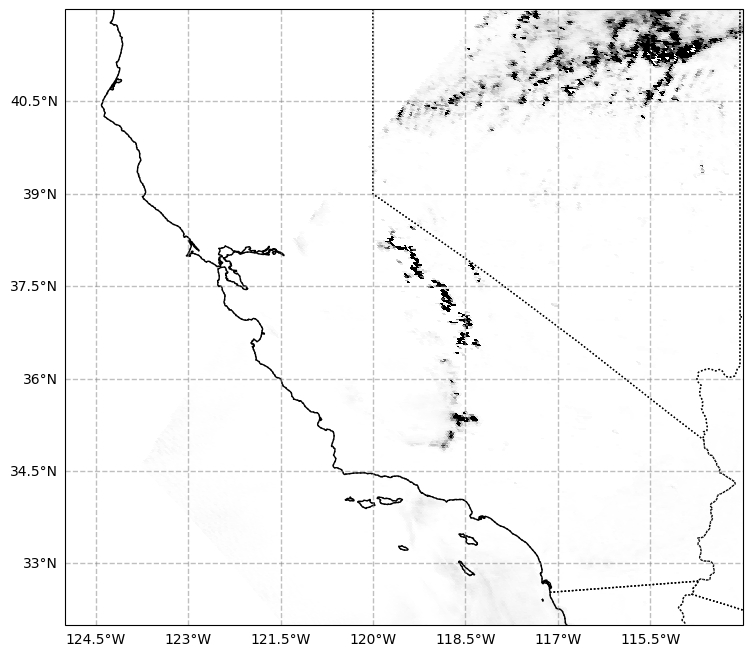

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(CloudOpticalDepthDataset['lon'][0,:,:], CloudOpticalDepthDataset['lat'][0,:,:], CloudOpticalDepthDataset['CloudOpticalDepth'][0,:,:], transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()


In [18]:
dataset_metadata = {
    "title": "Reflected SW Radiation (RSR)",
    "description": "Combined RSR data over time for Julian days 91 to 100.",
    "source": "GOES-16 Satellite Cloud and Moisture Imagery",
    "history": "Created on 2024-10-24 by combining RSR over time.",
    "institution": "University of Washington",
    "references": "https://registry.opendata.aws/noaa-goes/",
    "time_units": "Julian days",
    "lat_units": "degrees_north",
    "lon_units": "degrees_east",
    "rsr_units": "W/m2"
}
# Assuming time is represented by the Julian days 91 to 100
time = np.array([91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

# Extract the RGB data and lat/lon for all days
reflected_sw_rsr = np.array([data_dict[day]['reflected_sw']['rsr'] for day in data_dict])

# Extract lat/lon for each day (assuming lat/lon are 2D for each day)
reflected_sw_lat = np.array([data_dict[day]['reflected_sw']['lat'][:] for day in data_dict])
reflected_sw_lon = np.array([data_dict[day]['reflected_sw']['lon'][:] for day in data_dict])

# Stack the RGB data into a 4D array (time, lat, lon, rgb)
rsr_data = np.stack(reflected_sw_rsr, axis=0)

# Create the xarray Dataset with renamed coordinates
ReflectedSWDataset = xr.Dataset(
    {
        'ReflectedSW': (['time', 'latitude', 'longitude'], rsr_data)
    },
    coords={
        "time": ("time", time, {"units": dataset_metadata["time_units"]}),  # Add units directly to time
        "lat": (['time', 'latitude'], reflected_sw_lat, {"units": dataset_metadata["lat_units"]}),  # 1D latitude
        "lon": (['time', 'longitude'], reflected_sw_lon, {"units": dataset_metadata["lon_units"]}),  # 1D longitude
    },
    # name="CloudImagery",
    attrs=dataset_metadata  # Add metadata here
    
)

# Verify the structure of the Dataset
# print(ds)


In [19]:
ReflectedSWDataset

<xarray.Dataset>
Dimensions:      (time: 10, latitude: 166, longitude: 394)
Coordinates:
  * time         (time) int32 91 92 93 94 95 96 97 98 99 100
    lat          (time, latitude) float64 55.62 55.38 55.12 ... 14.62 14.38
    lon          (time, longitude) float64 -151.6 -151.4 ... -53.62 -53.38
Dimensions without coordinates: latitude, longitude
Data variables:
    ReflectedSW  (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    title:        Reflected SW Radiation (RSR)
    description:  Combined RSR data over time for Julian days 91 to 100.
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RSR over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rsr_units:    W/m2

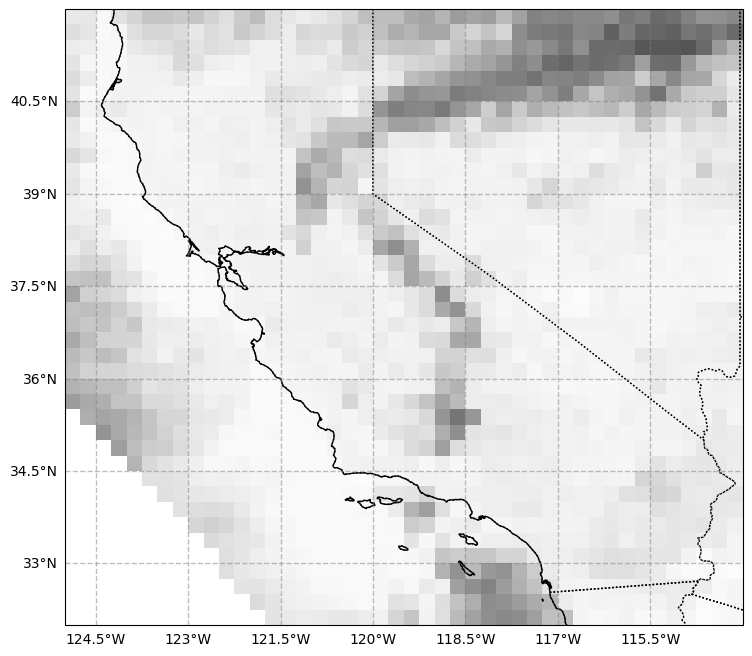

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(ReflectedSWDataset['lon'][0,:], ReflectedSWDataset['lat'][0,:], ReflectedSWDataset['ReflectedSW'][0,:,:], transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()


In [21]:
# Save CloudImageryDataset as a NetCDF file
CloudImageryDataset.to_netcdf("CloudImageryDataset.nc")

# Save CloudOpticalDepthDataset as a NetCDF file
CloudOpticalDepthDataset.to_netcdf("CloudOpticalDepthDataset.nc")

# Save ReflectedSWDataset as a NetCDF file
ReflectedSWDataset.to_netcdf("ReflectedSWDataset.nc")

# Confirmation
print("Datasets have been successfully saved as NetCDF files.")


Datasets have been successfully saved as NetCDF files.
